# Assignment 8: Policy gradients in Jax

In this assignment, you will implement the REINFORCE algorithm for the inverted pendulum swing-up problem. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

Like in the previous assignment, we will use the Jax framework for automatic differentiation. We (again) recommend you to look through the following articles to get started with the Jax framework:

- [Jax Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
- [Training a simple NN with Jax](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/neural_network_with_tfds_data.ipynb)
- [Jax vs. NumPy](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html)

In addition, we use two additional libraries, optax and gymnax, which are used for optimization and for simulating OpenAI gym models. Both packages can be installed via the pip package manager.

## 8.1 Using gymnax (0 points)
the following code sets up a gymnax environment for the inverted pendulum swing up, where we discretize the action space manually. The code below does not have to be changed, but it is recommend to try to understand observation and state representations of the pendulum.

In [1]:
!pip install gymnax
#!pip install optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 26.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827622 sha256=ca3f1f0e8d139c537c2b0a8f9316bfc7c27c19e385bc350c24ed35b7be056299
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
from jax.random import PRNGKey
import optax
import gymnax
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
key = PRNGKey(1337)
key, key_reset, key_policy, key_step = jr.split(key, 4)

# Create the Pendulum-v1 environment
env_name = "Pendulum-v1"
env, env_params = gymnax.make(env_name)

# Inspect default environment settings
print(env_params)
ts = jnp.arange(0, env_params.dt * env_params.max_steps_in_episode, env_params.dt)

obs, state = env.reset(key_reset, env_params)
obs, state

EnvParams(max_steps_in_episode=200, max_speed=8.0, max_torque=2.0, dt=0.05, g=10.0, m=1.0, l=1.0)


(Array([-0.6881745,  0.7255452,  0.5210209], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), theta=Array(2.3297663, dtype=float32), theta_dot=Array(0.5210209, dtype=float32), last_u=Array(0., dtype=float32, weak_type=True)))

In [4]:
action = env.action_space(env_params).sample(key_policy)
action_scalar = env.action_space()
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

(Array([-0.71618974,  0.6979056 ,  0.78714865], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), theta=Array(2.3691237, dtype=float32), theta_dot=Array(0.78714865, dtype=float32), last_u=Array(-1.8535409, dtype=float32)),
 Array(-5.458394, dtype=float32),
 Array(False, dtype=bool, weak_type=True))

For this assignment, we discretize the action space:

In [5]:
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_policy)
action_list = jnp.array([-1., 0., 1.])
num_actions = len(action_list)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action)

env_params

EnvParams(max_steps_in_episode=200, max_speed=8.0, max_torque=2.0, dt=0.05, g=10.0, m=1.0, l=1.0)

## 8.2 Setting up a basic neural network (3 points)

Create a basic neural network in Jax using jax.nn and jax.random for initialising the weights and biases randomly with a mean of zero and a small standard deviation.

Since the network represents the policy, it should take a state as input and output a predicted probability distribution over all discrete actions. Below is a suggested setup for the functions via which this can be done.

In [6]:
def initialize_mlp(layer_sizes, key:PRNGKey, scale:float=1e-2):
    """
    Inputs:
        layer_sizes (tuple) Tuple of shapes of the neural network layers. Includes the input shape, hidden layer shape, and output layer shape.
        key (PRNGKey)
        scale (float) standard deviation of initial weights and biases

    Return:
        params (List) Tuple of weights and biases - [ (weights_1, biases_1), ..., (weights_n, biases_n) ]
    """
    params = []
    for i in range(len(layer_sizes)-1):
        key, subkey = jr.split(key)
        weights = scale * jr.normal(subkey, shape=(layer_sizes[i], layer_sizes[i+1]))
        #biases = scale * jr.normal(subkey, shape=(1, layer_sizes[i+1]))
        biases = scale * jr.normal(subkey, shape=(layer_sizes[i+1],))
        params.append((weights, biases))
    return params

def policy(params, x):
    """ Standard MLP that predicts either -1, 0, 1.

    Inputs:
        params (PyTree) Parameters of the policy network, represented as PyTree.
        x (D,) input state, where D is the dimensionality of the state observation.
        """
    for weights, biases in params[:-1]:
      x = jnp.dot(x, weights) + biases
      x = jnn.relu(x)
    final_weights, final_biases = params[-1]
    x = jnp.dot(x, final_weights) + final_biases
    x = jnn.softmax(x)
    return x


In addition to the policy network, we will need some helper functions to do the following:

- Sample an action from the policy distribution.
- Calculate the log probability of an action given the policy distribution.
- Update the error terms $\delta$ during training (hint: the tree.map() function from question 1 is useful here).

In [7]:
def get_action(params, x, key:PRNGKey):
    """
    Sample an action using the action probabilities predicted by the MLP

    Input:
        params (PyTree) Parameters of the policy network, represented as PyTree.
        x (D,) input state, where D is the dimensionality of the state observation.
        key (PRNGKey)

    Return:
        action (M,) of floats: actions generated according to params, where M is the dimensionality of actions we carry out.
        action_idx (M,) of int: indices of actions generated according to params.
    """
    probs = policy(params, x)  # Get action probabilities from the policy network
    action_idx = jr.choice(key, a=len(probs), p=probs)  # Sample action index
    action = action_list[action_idx]  # Get corresponding action from action_list
    return action, action_idx

def get_log_prob(params, x, action_idx):
    """
    Return the log probability of the action executed by the MLP.

    Input:
        params (PyTree) Parameters of the policy network, represented as PyTree.
        x (D,) input state, where D is the dimensionality of the state observation.
        action_idx (M,) of int: indices of actions generated according to params.

    Return:
        log probability
    """
    probs = policy(params, x)
    # log_prob = jnp.log(jnp.take(action_probs, action_idx))
    log_prob = jnp.log(probs[action_idx])
    return log_prob

@jax.jit
def update_delta(delta, grad_theta):
    """
    Update the parameter update delta with the gradient of the policy.

    Input:
        delta (PyTree) current loss term
        grad_theta (PyTree) gradient update of the network parameters.

    Return:
        updated_delta (PyTree)
    """
    updated_delta = jax.tree.map(lambda x, y: x + y, delta, grad_theta)
    return updated_delta, None # you can leave the second return (None) for functionality of training loop.

In [8]:
# initialize the policy
obs_dim = obs.shape[0]
hidden_layer_size = 32
layer_sizes = (obs_dim, hidden_layer_size, hidden_layer_size, num_actions)
key, subkey = jr.split(key)
params = initialize_mlp(layer_sizes, subkey)

[2879645606  264818771]


## Intermezzo: generating rollouts of the pendulum in parallel with Gymnax.
The following code generates batched rollouts of the environment in parallel. Note that it requires the 'get_action' function that should have been implemented above.

In [11]:
def rollout(params, env_params, rng_input:PRNGKey, steps_in_episode:int):
    """Rollout a jitted gymnax episode with lax.scan."""
    # Reset the environment
    rng_reset, rng_episode = jr.split(rng_input)
    obs, state = env.reset(rng_reset, env_params)


    def policy_step(state_input, tmp):
        """lax.scan compatible step transition in jax env."""
        obs, state, rng = state_input
        rng, rng_action, rng_step = jr.split(rng, 3)
        action, action_idx = get_action(params, obs, rng_action)
        next_obs, next_state, reward, done, _ = env.step(
          rng_step, state, action, env_params
        )
        carry = [next_obs, next_state, rng]
        return carry, [obs, state, action, action_idx, reward, next_obs, done]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      policy_step,
      [obs, state, rng_episode],
      (),
      length=steps_in_episode,
    )
    return scan_out

# Jit-Compiled Episode Rollout
jit_rollout = jax.jit(rollout, static_argnums=3)

In [12]:
def visualize_trajectory(params, key):
    obs, state, action, action_idx, reward, next_obs, done = rollout(params, env_params, rng_input=key, steps_in_episode=env_params.max_steps_in_episode)


    fig, ax = plt.subplots(5,1,figsize=(8,8))
    # first three plots for the system states
    ax[0].set_title('System states over time')

    for d in range(env.obs_shape[0]):
        ax[d].plot(ts, obs[:,d], color='C0', label=f'State {d}')
    ax[0].set_title(r'$\cos(\theta)$')
    ax[1].set_title(r'$\sin(\theta)$')
    ax[2].set_title(r'$\dot{\theta}$')

    ax[3].plot(ts, action, color='C1', label=f'Actions')
    # ax[3].set_ylim((env.action_space().low, env.action_space().high))
    ax[3].set_title('u(t)')
    ax[4].plot(ts, reward, color='C2', label='Rewards')
    ax[4].set_title('r(t)')

    plt.tight_layout()
    plt.show()

Caption 1: Single rollout using the policy network without training


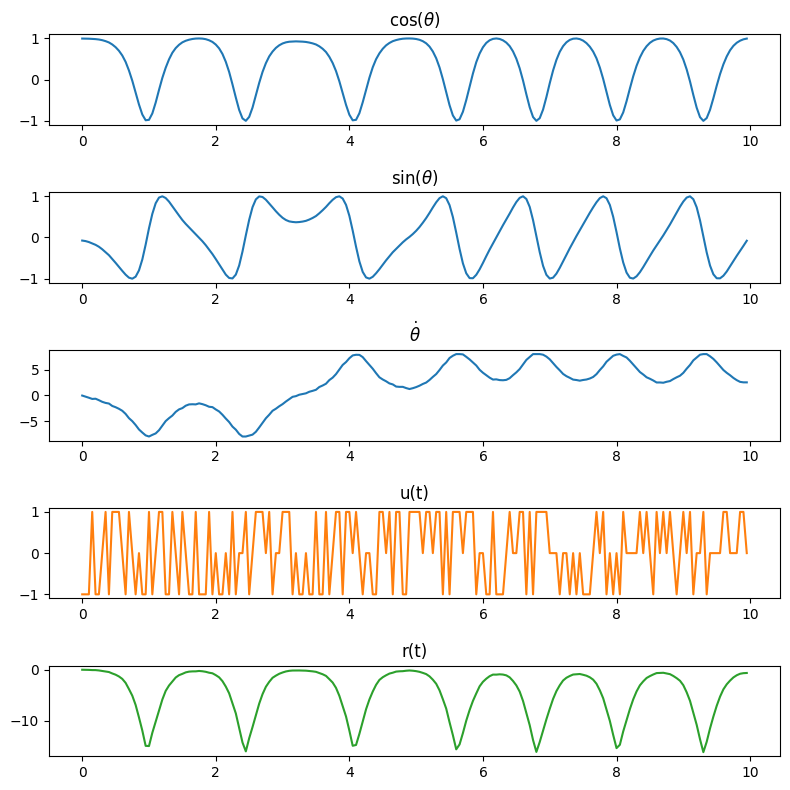

In [13]:
key, subkey = jr.split(key)
print('Caption 1: Single rollout using the policy network without training')
visualize_trajectory(params,key = subkey)

## 8.3 REINFORCE without baseline (4 points)

Implement the REINFORCE algorithm from the lecture notes (algorithm 1) to compute the error terms to update the parameters. Make use of get_log_prob and update_delta functions implemented earlier.

For iterating over the time steps, we recommend using the jax.lax.scan function. To parallelize the gradients across batches, it is recommended to use jax.vmap function. Note that either of them are possible using for loops too, however using these methods will drastically speed up the code.

To get you started, the training loop is already defined below. As such, you will have to implemenet the REINFORCE loss and choose the learning parameters.

### **Algorithm 1:** REINFORCE Algorithm (Episodic)
1. **Initialize** $\theta$
2. **Loop**:
   1. Generate a set of trajectories $\tau_1, \dots, \tau_M$ by following $\pi_\theta$.
   2. $\delta \gets 0$
   3. For each trajectory $\tau_m$:
      1. $G \gets 0$
      2. For $n = T - 1, \dots, 1$:
         1. $G \gets \gamma G + r_{n+1}^{(m)}$
         2. $\delta \gets \delta + \nabla_\theta \log \pi_\theta \left(u_n^{(m)} \mid x_n^{(m)}\right) G$
      3. End For
   4. End For
   5. $\theta \gets \theta + \eta \delta$  
      *Gradient descent to reduce actions that lead to higher costs.*
3. **End Loop**


In [14]:
def loss_REINFORCE(params, obs, action_idx, reward, baseline, gamma:float=0.99):
    """
    Compute the error term delta using the REINFORCE algorithm

    Inputs:
        params (PyTree) Current parameters of the network
        obs (Array) Batch of observations
        action_idx (Array) Batch of action indices
        reward (Array) Batch of rewards
        baseline (Array) Baseline over time points - not required for current question 8.3.

    Return:
        delta (PyTree) Error terms of the parameters
        Gt (Array) Batched discounted rewards over time
    """

    def trajectory_gradients(reward, obs, action_idx, baseline, delta):
        G_init = 0

        def step(carry, variables):
            G, delta = carry
            r, obs, action_idx, baseline = variables

            """
            YOUR CODE HERE
            """

            carry = G, delta
            return carry, G

        #Iterate backwards in time
        variables = (reward[::-1],
                     obs[::-1],
                     action_idx[::-1],
                     baseline[::-1])

        """ WRITE YOUR SCAN FUNCTION HERE THAT CALLS step()"""
        (_, delta), Gt = jax.lax.scan(None)
        return delta, Gt

    # create a parallizable function and initialize the error terms delta.
    """ VMAP THE trajectory_gradients() OVER THE BATCH SIZE"""
    parallel_trajectory_gradients = jax.vmap(None)

    # compute the delta gradients in parallel and sum them up.
    delta = jax.tree.map(lambda t: jnp.zeros(t.shape), params)
    deltas, Gs = parallel_trajectory_gradients(reward, obs, action_idx, baseline, delta)
    delta, _ = jax.lax.scan(update_delta, delta, deltas)

    return delta, jnp.array(Gs)

# Jit the function for computational efficiency. Note: for printing inside the function, do not jit this by commenting the below line.
loss_REINFORCE = jax.jit(loss_REINFORCE)

In [ ]:
# set training parameters
num_iters = None
steps_in_episode = env_params.max_steps_in_episode
lr = None
gamma = None
n_batches = None

optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
plt.plot(history, label='loss')
plt.show()

In [ ]:
visualize_trajectory(params, subkey)
key, subkey = jr.split(key)

## 8.4 Create (time-dependent) baseline (3 points)

Implement a baseline $b(t) = E[ G_t] $ following Algorithm 2 in the lecture notes. Rather than minimizing $| G_n - b(x_n)|^2$, you can instead take the average discounted reward as a constant baseline, or compute the time-dependent baseline by averaging over the cumulative discounted rewards over time.

Hint: this should be possible by only altering the training loop function, without altering the REINFORCE loss function.

Comment on the effect of adding the baseline, and explain how this impacts the training of the network.

### **Algorithm 2:** Policy Gradient with Baseline (Episodic)
1. **Initialize** $\theta$
2. **Loop**:
   1. Generate a set of trajectories $\tau_1, \dots, \tau_M$ by following $\pi_\theta$.
   2. $\delta \gets 0$
   3. For each trajectory $\tau_m$:
      1. $G \gets 0$
      2. For $n = T - 1, \dots, 1$:
         1. $G \gets \gamma G + r_{n+1}^{(m)}$
         2. $\hat{A} \gets G - b(x_n)$
         3. $\delta \gets \delta + \nabla_\theta \log \pi_\theta \left(u_n^{(m)} \mid x_n^{(m)}\right) \hat{A}$
      3. End For
   4. End For
   5. $\theta \gets \theta + \eta \delta$
   6. Refit the baseline by minimizing $\lVert G_n - b(x_n) \rVert^2$ over trajectories and timesteps.
3. **End Loop**


## 8.4 Create (time-dependent) baseline (3 points)

Implement a baseline $b(t) = E[ G_t] $ following Algorithm 2 in the lecture notes. Rather than minimizing $| G_n - b(x_n)|^2$, you can instead:
* take the average discounted reward as a constant baseline,
* or compute the time-dependent baseline by averaging over the cumulative discounted rewards over time.

Hint: this should be possible by only altering the training loop function, without altering the REINFORCE loss function.

Comment on the effect of adding the baseline, and explain how this impacts the training of the network.

### **Algorithm 2:** Policy Gradient with Baseline (Episodic)
1. **Initialize** $\theta$
2. **Loop**:
   1. Generate a set of trajectories $\tau_1, \dots, \tau_M$ by following $\pi_\theta$.
   2. $\delta \gets 0$
   3. For each trajectory $\tau_m$:
      1. $G \gets 0$
      2. For $n = T - 1, \dots, 1$:
         1. $G \gets \gamma G + r_{n+1}^{(m)}$
         2. $\hat{A} \gets G - b(x_n)$
         3. $\delta \gets \delta + \nabla_\theta \log \pi_\theta \left(u_n^{(m)} \mid x_n^{(m)}\right) \hat{A}$
      3. End For
   4. End For
   5. $\theta \gets \theta + \eta \delta$
   6. Refit the baseline by minimizing $\lVert G_n - b(x_n) \rVert^2$ over trajectories and timesteps.
3. **End Loop**
